Import the required dependencies

In [2]:
import serdespy as sdp
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
import scipy as sp
from si_prefix import si_format

In [3]:
# Insert custom values for the PLL
Fref = 125e6  # Reference Frequency
N = 20  # Multiplication Factor
Rz = 8e3  # Zero Resistor Value
Icp = 90e-6  # Charge Pump current
tau = 60e-12  # Charge Pump Pulse
KVCO_HzV = 1.8e9  # VCO Gain in Hz/V
Cunit = 1e-12  # Unitary Capacitor for Capacitor ratio
C1 = 24 * Cunit
C2 = 0.5 * Cunit

Now we calculate the main parameteres

In [4]:
# PLL calculations
f0 = Fref * N  # Output Frequency
KVCOrad = (2 * np.pi) * KVCO_HzV  # VCO gain in rad/s
KVCO = KVCOrad  # For future calculations
KPD = Icp / (2 * np.pi)  # Charge pump Gain
print('KVCO: '+si_format(KVCO_HzV)+'Hz/V')
print('KPD: '+si_format(KPD)+'A/V')
print('f0: '+si_format(f0)+'Hz')

KVCO: 1.8 GHz/V
KPD: 14.3 µA/V
f0: 2.5 GHz


Open loop and closed loop transfer function calculations

In [5]:
# Transfer function
#               n0 + n1s   
# H(s) = ------------------------
#        d0 + d1s + d2s^2 + d3s^3

#               n1s + n0   
# H(s) = ------------------------
#        d3s^3 + d2s^2 + d1s + d0
# n0 = KPD * KVCO
# n1 = C1 * KPD * KVCO * Rz
# d0 = 0
# d1 = 0
# d2 = (C1 + C2) * N
# d3 = C1 * C2 * N * Rz

import types
LG = types.SimpleNamespace()
CL = types.SimpleNamespace()

# Open Loop
LG.n0 = KPD * KVCO
LG.n1 = C1 * KPD * KVCO * Rz
LG.d0 = 0
LG.d1 = 0
LG.d2 = (C1 + C2) * N
LG.d3 = C1 * C2 * N * Rz
LG.num = [LG.n1, LG.n0]
LG.den = [LG.d3, LG.d2, LG.d1, LG.d0]

# Closed Loop
CL.n0 = KPD * KVCO * N
CL.n1 = C1 * KPD * KVCO * N * Rz
CL.d0 = KPD * KVCO
CL.d1 = C1 * KPD * KVCO * Rz
CL.d2 = C1 * N + C2 * N
CL.d3 = C1 * C2 * N * Rz
CL.num = [CL.n1, CL.n0]
CL.den = [CL.d3, CL.d2, CL.d1, CL.d0]

Plot results

Settling Time: N/A


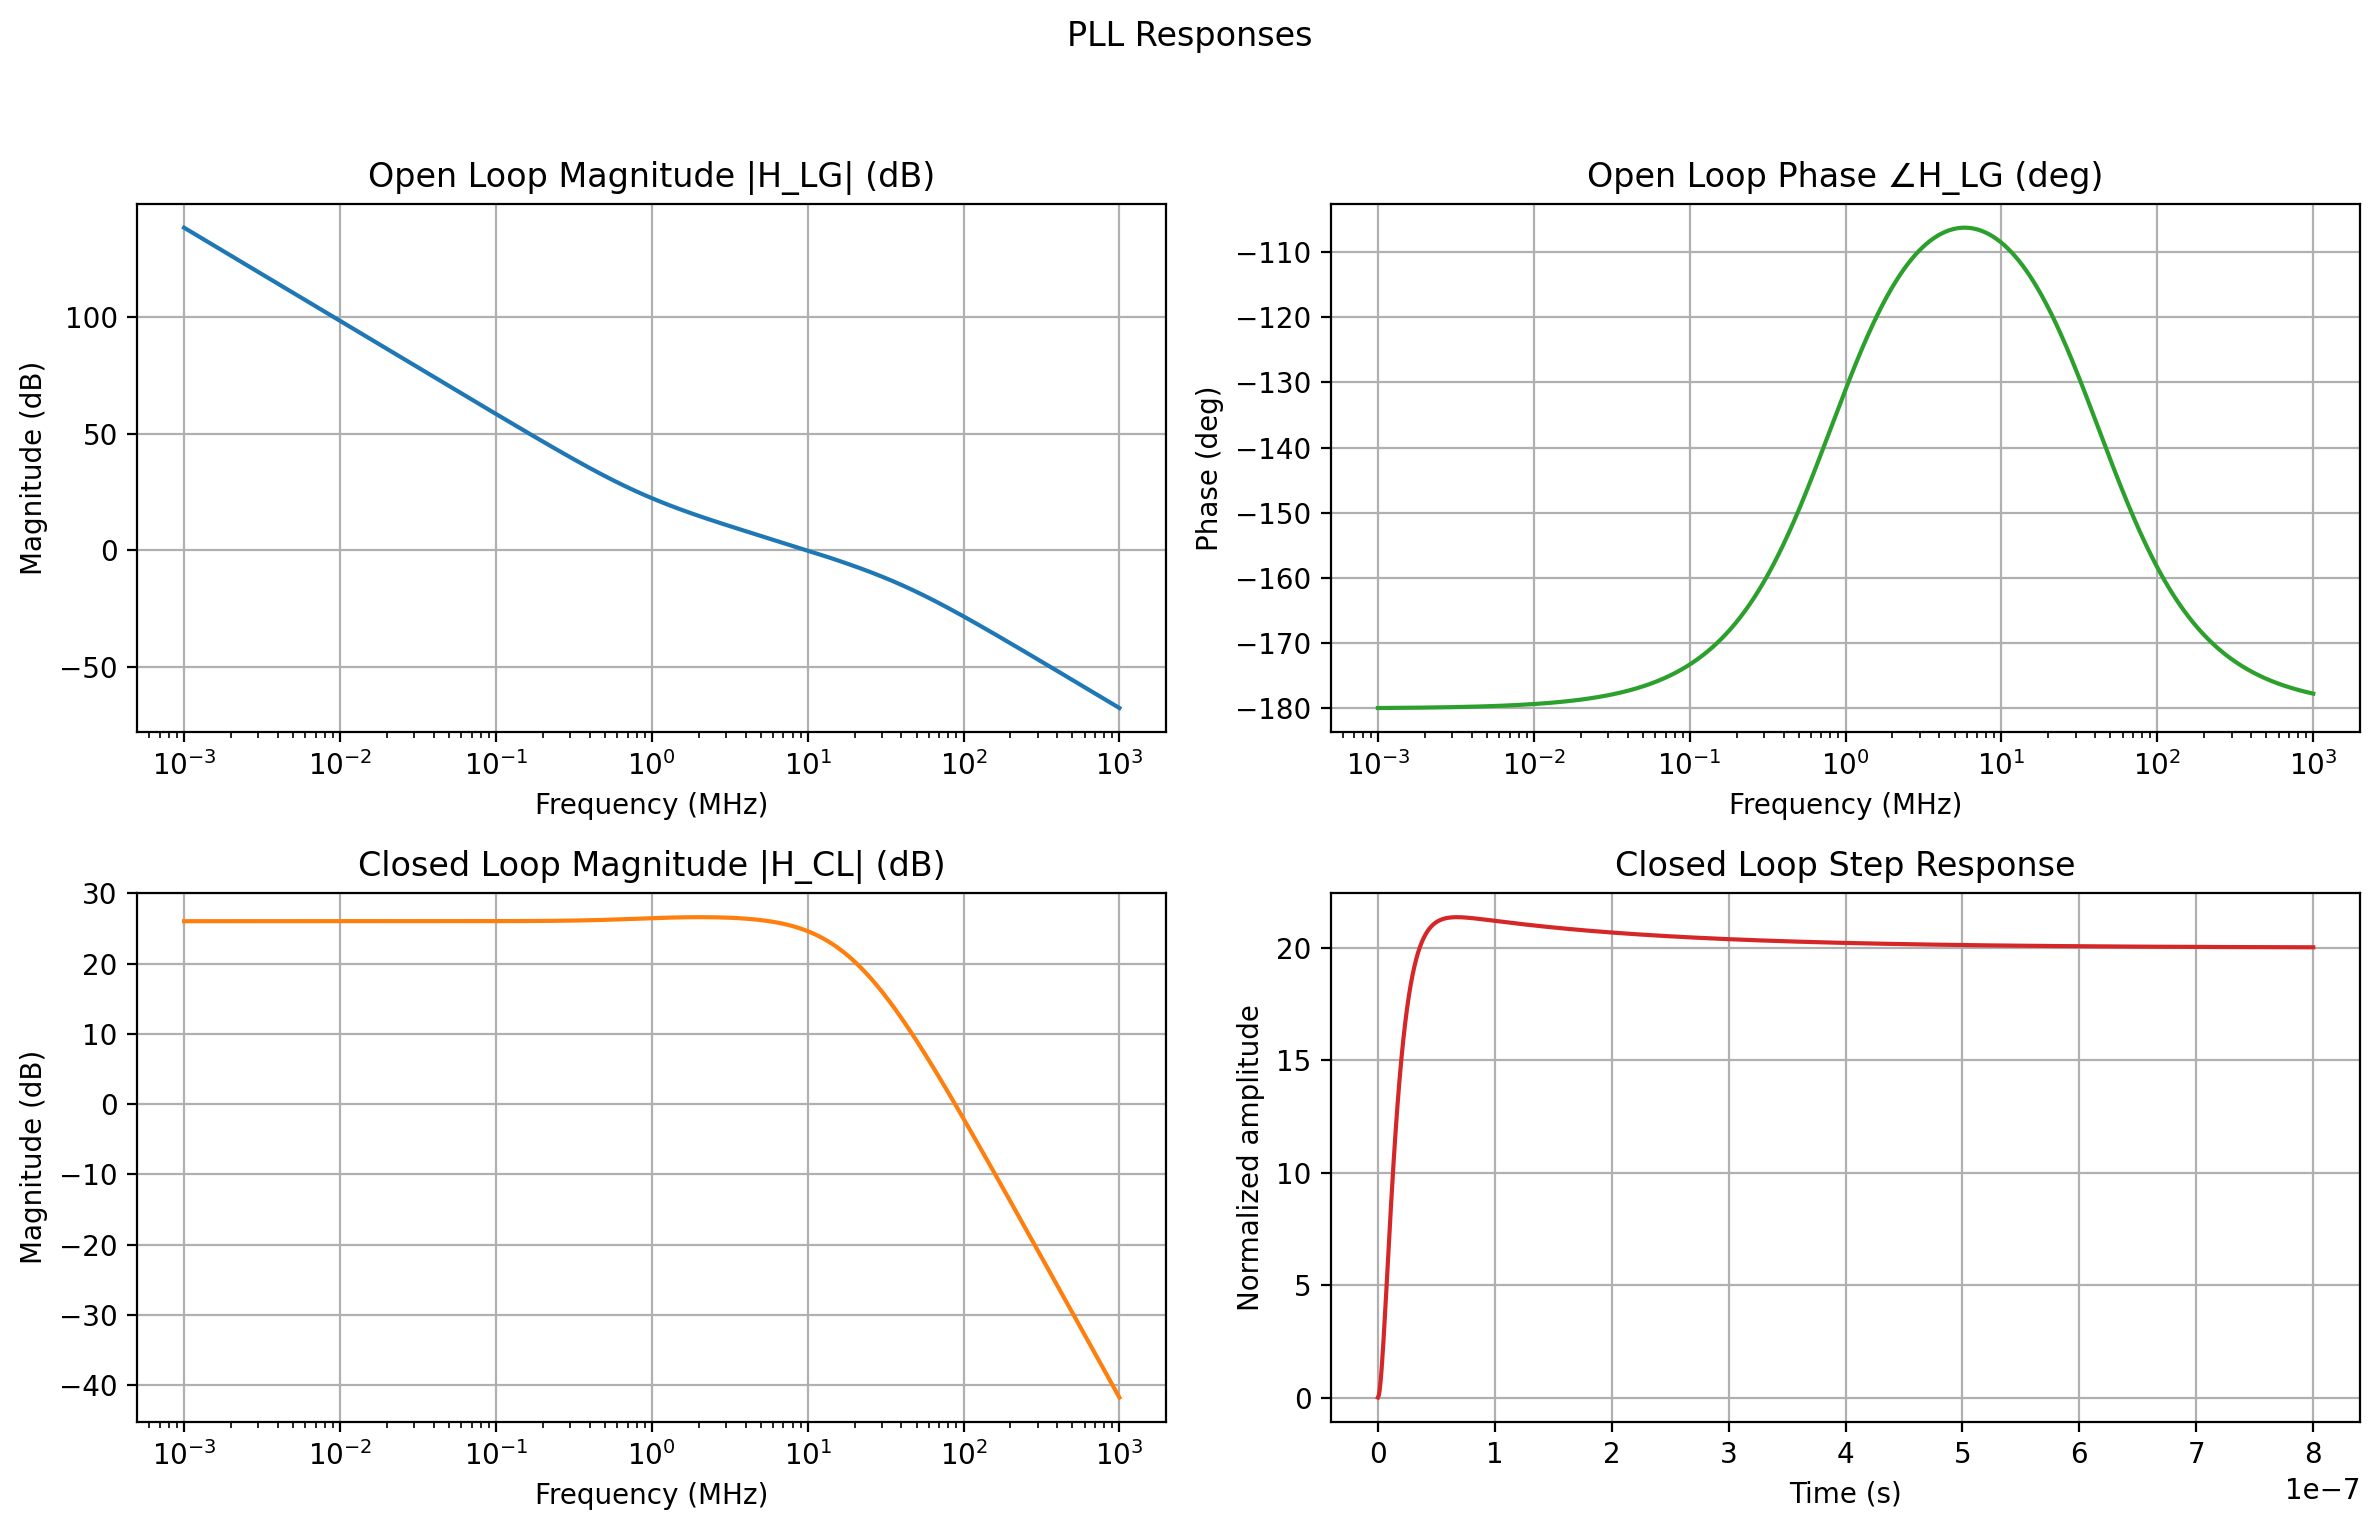

In [6]:
# Frequency Response
f = np.logspace(3, 9, num=1000)  # Frequency range from 1kHz to 1GHz
w = 2 * np.pi * f  # Angular frequency

# Open Loop Frequency Response (magnitude and phase)
w, H_LG = sp.signal.freqs(LG.num, LG.den, w)
H_LG_mag_db = 20 * np.log10(np.abs(H_LG))
H_LG_phase_deg = np.unwrap(np.angle(H_LG)) * 180.0 / np.pi

# Closed Loop Frequency Response (magnitude)
w, H_CL = sp.signal.freqs(CL.num, CL.den, w)
H_CL_mag_db = 20 * np.log10(np.abs(H_CL))

# Closed Loop step response (time-domain)
# choose a time vector that spans a few natural periods based on f0
t = np.linspace(0, 100 / Fref, 1000)
t_out, H_CL_step = sp.signal.step((CL.num, CL.den), T=t)

# Settling time calculation (2% criterion) — using the step response
settling_time_idx = np.where(np.abs(H_CL_step - 1) < 0.02)[0]
if len(settling_time_idx) > 0:
    settling_time = t_out[settling_time_idx[0]]
else:
    settling_time = np.nan
if np.isfinite(settling_time):
    print('Settling Time: ' + si_format(settling_time) + 's')
else:
    print('Settling Time: N/A')

# Plot four independent subplots (2x2)
fig, axs = plt.subplots(2, 2, figsize=(12, 8), dpi=200)

# Top-left: Open Loop magnitude
axs[0, 0].semilogx(1e-6 * f, H_LG_mag_db, color='tab:blue')
axs[0, 0].set_title('Open Loop Magnitude |H_LG| (dB)')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Magnitude (dB)')
axs[0, 0].grid(True)

# Top-right: Open Loop phase
axs[0, 1].semilogx(1e-6 * f, H_LG_phase_deg, color='tab:green')
axs[0, 1].set_title('Open Loop Phase ∠H_LG (deg)')
axs[0, 1].set_xlabel('Frequency (MHz)')
axs[0, 1].set_ylabel('Phase (deg)')
axs[0, 1].grid(True)

# Bottom-left: Closed Loop magnitude
axs[1, 0].semilogx(1e-6 * f, H_CL_mag_db, color='tab:orange')
axs[1, 0].set_title('Closed Loop Magnitude |H_CL| (dB)')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Magnitude (dB)')
axs[1, 0].grid(True)

# Bottom-right: Closed Loop step response
axs[1, 1].plot(t_out, H_CL_step, color='tab:red')
axs[1, 1].set_title('Closed Loop Step Response')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Normalized amplitude')
axs[1, 1].grid(True)

plt.suptitle('PLL Responses')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()